In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Bahia - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_BA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Bahia - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.299858,10915.348400,151.297,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.301903,11028.218400,138.707,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.303709,11133.335807,135.009,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.305311,11215.137236,126.554,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.306860,11294.955512,137.331,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


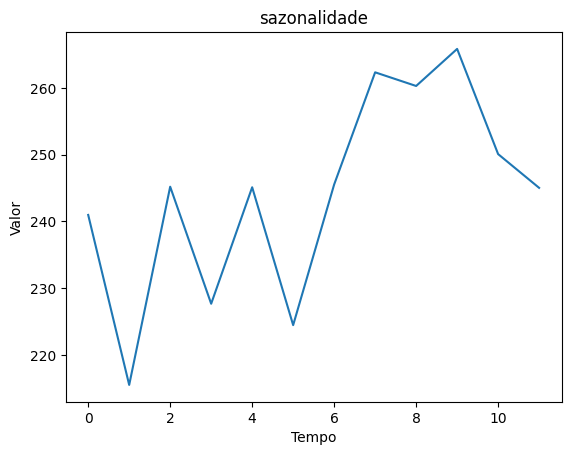

,sazonalidade
sazonalidade,
0,240.981090
1,215.539900
2,245.202066
3,227.688361
4,245.118647
5,224.488539
6,245.532886
7,262.321346
8,260.276762


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Bahia - Consumo de Cimento (t)
0,2003-1,0.299858,10915.348400,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,240.981090,151.297
1,2003-2,0.301903,11028.218400,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,215.539900,138.707
2,2003-3,0.303709,11133.335807,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,245.202066,135.009
3,2003-4,0.305311,11215.137236,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,227.688361,126.554
4,2003-5,0.306860,11294.955512,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,245.118647,137.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.118647,NaN
269,2002-9,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.488539,NaN
270,2002-10,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.532886,NaN
271,2002-11,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.321346,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Bahia - Consumo de Cimento (t), Length: 273, dtype: float64

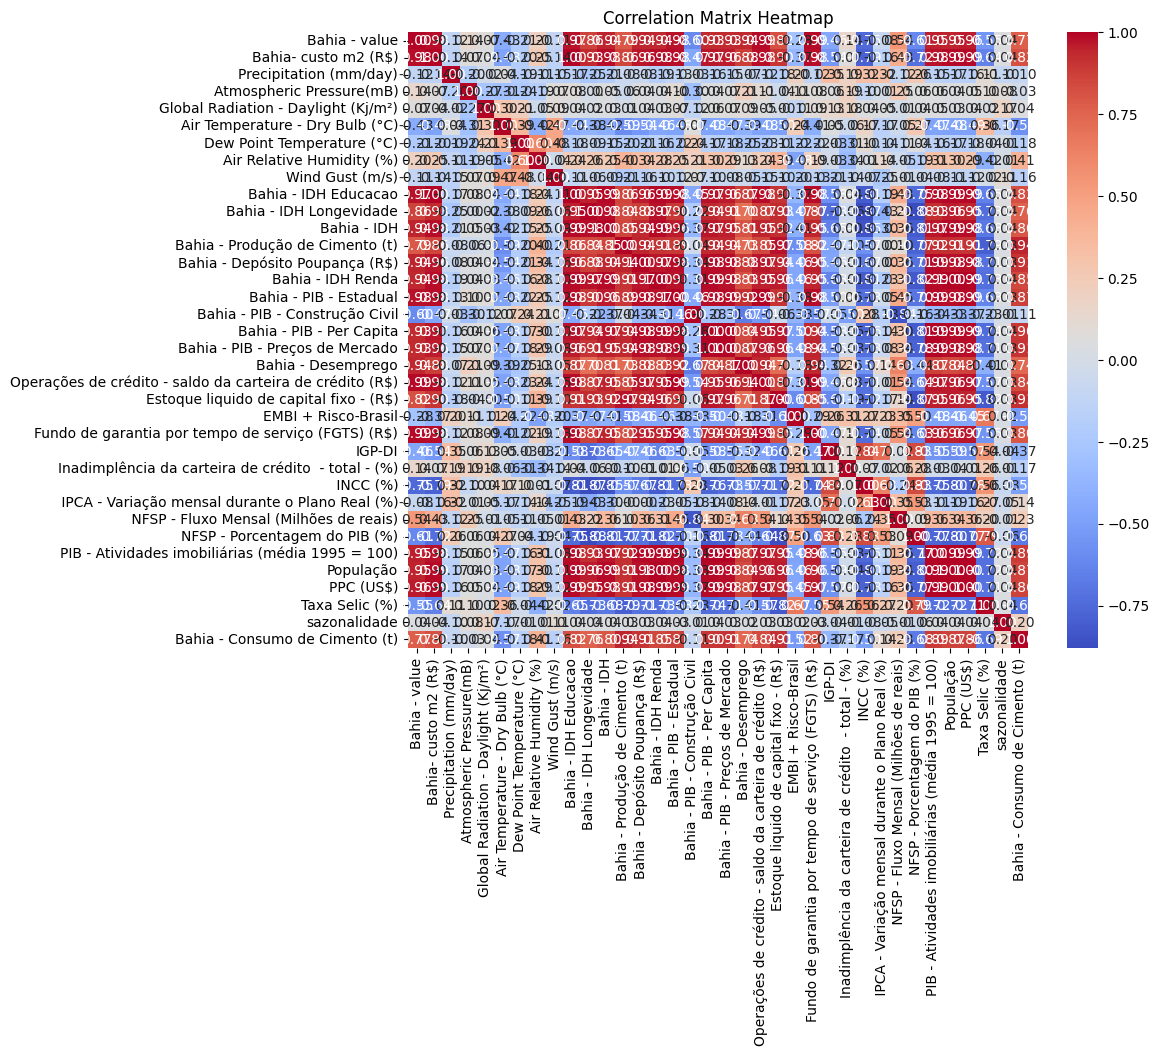

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Bahia - value,1.081891e+06
1,Bahia- custo m2 (R$),2.748305e+06
2,Precipitation (mm/day),7.884917e+01
3,Atmospheric Pressure(mB),4.042280e+06
4,Global Radiation - Daylight (Kj/m²),7.126118e+02
5,Air Temperature - Dry Bulb (°C),2.375734e+04
6,Dew Point Temperature (°C),5.056837e+03
7,Air Relative Humidity (%),2.999788e+04
8,Wind Gust (m/s),4.949185e+02
9,Bahia - IDH Educacao,1.127392e+09


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.299858,10915.348400,1.604227,1669.734463,26.973700,22.147525,75.411587,2.004234,39.798880,7.782609e+06,1.317344e+08,8.384593e+06,8.348779,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,240.981090
1,0.301903,11028.218400,2.224533,1568.727444,26.728784,22.241910,76.966756,1.726139,39.480034,7.827094e+06,1.318964e+08,8.391946e+06,8.342979,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,215.539900
2,0.303709,11133.335807,2.312330,1452.272884,26.305364,22.159668,78.493126,1.462602,39.400256,7.871579e+06,1.320584e+08,8.399299e+06,8.337179,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,245.202066
3,0.305311,11215.137236,2.332765,1359.230366,25.788306,21.728601,78.801800,1.217048,39.417185,7.916064e+06,1.322204e+08,8.406652e+06,8.331379,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,227.688361
4,0.306860,11294.955512,2.225842,1291.737281,25.189925,21.303605,79.547467,1.031926,39.479943,7.960549e+06,1.323824e+08,8.414005e+06,8.325579,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,245.118647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.476605,24167.020501,1.537428,1418.281420,24.686518,20.094589,76.227985,1.593444,91.995691,2.010533e+07,1.564800e+08,8.241231e+06,15.607881,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,262.321346
176,0.478697,24257.282126,1.715185,1490.406042,25.138703,20.393141,75.659901,1.597502,91.964124,2.019305e+07,1.564497e+08,8.240050e+06,15.604469,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,260.276762
177,0.480679,24345.838739,1.888699,1558.871017,25.697088,20.758309,74.930777,1.560874,92.171781,2.028076e+07,1.564195e+08,8.238870e+06,15.601056,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,265.822767
178,0.481471,24432.887826,1.788348,1591.633436,26.156110,21.152716,74.760722,1.542429,92.052788,2.036848e+07,1.563892e+08,8.237689e+06,15.597644,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,250.083880


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Bahia- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.679365,-0.018747,1.225595,0.610311,0.008691,-0.181672,1.337807,-1.650237,-1.532772,-1.646879,-0.996444,-0.818821,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040
1,-1.650551,1.217740,0.705387,0.404623,0.039131,0.129230,0.455378,-1.662829,-1.522961,-1.627694,-0.949829,-0.820524,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580
2,-1.623716,1.392750,0.105622,0.049022,0.012607,0.434375,-0.380852,-1.665979,-1.513149,-1.608509,-0.903215,-0.822226,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368
3,-1.602833,1.433483,-0.373566,-0.385219,-0.126416,0.496084,-1.160025,-1.665311,-1.503338,-1.589324,-0.856600,-0.823929,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384
4,-1.582457,1.220348,-0.721170,-0.887757,-0.263481,0.645154,-1.747436,-1.662832,-1.493526,-1.570138,-0.809986,-0.825632,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.703597,-0.151900,-0.069441,-1.310534,-0.653400,-0.018461,0.034323,0.411133,1.185078,1.283512,-1.905278,1.312242,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938
176,1.726639,0.202432,0.302016,-0.930776,-0.557115,-0.132030,0.047198,0.409887,1.204425,1.279927,-1.912764,1.311240,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688
177,1.749247,0.548307,0.654625,-0.461827,-0.439345,-0.277793,-0.069026,0.418087,1.223772,1.276342,-1.920249,1.310238,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616
178,1.771469,0.348271,0.823358,-0.076326,-0.312145,-0.311790,-0.127553,0.413388,1.243118,1.272758,-1.927734,1.309236,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Bahia- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.679365,-0.018747,1.225595,0.610311,0.008691,-0.181672,1.337807,-1.650237,-1.532772,-1.646879,-0.996444,-0.818821,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040
1,-1.650551,1.217740,0.705387,0.404623,0.039131,0.129230,0.455378,-1.662829,-1.522961,-1.627694,-0.949829,-0.820524,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580
2,-1.623716,1.392750,0.105622,0.049022,0.012607,0.434375,-0.380852,-1.665979,-1.513149,-1.608509,-0.903215,-0.822226,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368
3,-1.602833,1.433483,-0.373566,-0.385219,-0.126416,0.496084,-1.160025,-1.665311,-1.503338,-1.589324,-0.856600,-0.823929,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384
4,-1.582457,1.220348,-0.721170,-0.887757,-0.263481,0.645154,-1.747436,-1.662832,-1.493526,-1.570138,-0.809986,-0.825632,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.428503,-0.824761,0.088610,-0.639039,-0.503765,-0.296263,-0.257511,0.515788,0.987961,1.301773,-1.715474,1.346223,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090
164,1.450155,-0.967080,0.471697,-0.343360,-0.425313,-0.384261,-0.188812,0.503986,1.000299,1.303139,-1.742955,1.340829,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875
165,1.472497,-0.802545,0.999680,0.000672,-0.376653,-0.583257,-0.099226,0.501383,1.012637,1.304505,-1.770437,1.335435,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030
166,1.494794,-0.401380,1.099294,0.229230,-0.340132,-0.700735,-0.097607,0.493451,1.024975,1.305871,-1.797918,1.330042,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
163    292.688
164    258.881
165    276.879
166    255.774
167    208.326
Name: Bahia - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Bahia- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
132,0.748721,0.252449,1.025606,0.123917,0.096241,0.603518,-0.194883,1.089633,1.295243,1.036921,-0.213487,1.163784,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376
133,0.770285,0.404743,0.652077,0.086257,0.134604,0.761624,-0.173909,1.075078,1.281528,1.051129,-0.275738,1.177052,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859
134,0.790820,0.568999,0.229526,-0.080211,0.097829,0.834678,-0.216333,1.061504,1.267813,1.065336,-0.337988,1.190321,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952
135,0.814033,0.388759,-0.318535,-0.456290,0.008077,0.986856,-0.149842,1.047242,1.254098,1.079543,-0.400239,1.203589,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200
136,0.835461,0.372070,-0.764010,-0.968669,-0.144691,1.100423,-0.112031,1.032520,1.240382,1.093751,-0.462489,1.216857,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944
137,0.856908,0.218369,-0.742124,-1.253126,-0.264563,1.057956,-0.041415,1.017173,1.226667,1.107958,-0.524740,1.230126,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692
138,0.878555,-0.426523,-0.529651,-1.336792,-0.326612,0.968398,0.219025,1.001228,1.212952,1.122166,-0.586991,1.243394,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126
139,0.900631,-0.617916,-0.350489,-1.251570,-0.347713,0.819420,0.379375,0.984640,1.199237,1.136373,-0.649241,1.256663,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065
140,0.922830,-0.254937,-0.106317,-1.017572,-0.306207,0.696401,0.404977,0.967535,1.185522,1.150581,-0.711492,1.269931,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206
141,0.945323,-0.397506,0.285348,-0.668842,-0.274516,0.420351,0.349698,0.949944,1.171807,1.164788,-0.773742,1.283200,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3456204203, 3831047323, 4154734579, 3720363923, 2987299670, 1355734360, 3599733262, 2521154111, 1174882746, 3553932268]


Step: 0 ___________________________________________
val_loss: 450.17974853515625
winner_seed: 3456204203


Step: 1 ___________________________________________
val_loss: 796.8505859375


Step: 2 ___________________________________________
val_loss: 141659568.0


Step: 3 ___________________________________________
val_loss: 763.841064453125


Step: 4 ___________________________________________
val_loss: 644.621826171875


Step: 5 ___________________________________________
val_loss: 46571008.0


Step: 6 ___________________________________________
val_loss: 796.057861328125


Step: 7 ___________________________________________
val_loss: 857.2654418945312


Step: 8 ___________________________________________
val_loss: 862645053816832.0


Step: 9 ___________________________________________
val_loss: 1680.153076171875


final_seed: 3456204203


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3456204203

Epoch 1/10000
4/4 [==============================] - 2s 114ms/step - loss: 56105.4375 - val_loss: 2704.5825
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 2222.8271 - val_loss: 1669.3021
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 2308.2668 - val_loss: 3551.9097
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 2456.4646 - val_loss: 2331.4915
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 2182.6204 - val_loss: 2020.9261
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 2071.8821 - val_loss: 2888.3716
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 2370.7515 - val_loss: 3657.2466
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 2597.8457 - val_loss: 3705.1328
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 2116.3840 - val_loss: 2869.7549
Epoch 10/10000
4/4 [==============================] 

4/4 [==============================] - 0s 8ms/step - loss: 250.2910 - val_loss: 729.5574
Epoch 158/10000
4/4 [==============================] - 0s 7ms/step - loss: 313.9366 - val_loss: 833.2035
Epoch 159/10000
4/4 [==============================] - 0s 7ms/step - loss: 243.6338 - val_loss: 775.1036
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 250.1454 - val_loss: 836.0104
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 250.1199 - val_loss: 716.0347
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 244.5883 - val_loss: 831.2516
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 252.6077 - val_loss: 832.5975
Epoch 164/10000
4/4 [==============================] - 0s 7ms/step - loss: 244.8038 - val_loss: 773.2059
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 259.6283 - val_loss: 861.6304
Epoch 166/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 174.7419 - val_loss: 701.1108
Epoch 314/10000
4/4 [==============================] - 0s 7ms/step - loss: 171.6125 - val_loss: 679.0537
Epoch 315/10000
4/4 [==============================] - 0s 7ms/step - loss: 176.6540 - val_loss: 669.4888
Epoch 316/10000
4/4 [==============================] - 0s 8ms/step - loss: 163.4248 - val_loss: 690.4930
Epoch 317/10000
4/4 [==============================] - 0s 8ms/step - loss: 154.4853 - val_loss: 695.5034
Epoch 318/10000
4/4 [==============================] - 0s 7ms/step - loss: 153.7461 - val_loss: 654.5076
Epoch 319/10000
4/4 [==============================] - 0s 7ms/step - loss: 164.8799 - val_loss: 920.1639
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 169.7174 - val_loss: 819.9295
Epoch 321/10000
4/4 [==============================] - 0s 7ms/step - loss: 179.5319 - val_loss: 776.4633
Epoch 322/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 196.8250 - val_loss: 724.9053
Epoch 470/10000
4/4 [==============================] - 0s 7ms/step - loss: 218.3512 - val_loss: 759.7703
Epoch 471/10000
4/4 [==============================] - 0s 7ms/step - loss: 235.0554 - val_loss: 870.7473
Epoch 472/10000
4/4 [==============================] - 0s 7ms/step - loss: 222.7811 - val_loss: 850.0540
Epoch 473/10000
4/4 [==============================] - 0s 7ms/step - loss: 199.0471 - val_loss: 917.4969
Epoch 474/10000
4/4 [==============================] - 0s 8ms/step - loss: 277.6775 - val_loss: 820.5121
Epoch 475/10000
4/4 [==============================] - 0s 8ms/step - loss: 199.6091 - val_loss: 974.9668
Epoch 476/10000
4/4 [==============================] - 0s 7ms/step - loss: 194.6140 - val_loss: 842.9354
Epoch 477/10000
4/4 [==============================] - 0s 7ms/step - loss: 226.9128 - val_loss: 813.7268
Epoch 478/10000
4/4 [==============================] - 0s 7ms/step - lo

Epoch 626/10000
4/4 [==============================] - 0s 7ms/step - loss: 66.8813 - val_loss: 884.4336
Epoch 627/10000
4/4 [==============================] - 0s 7ms/step - loss: 71.2085 - val_loss: 868.8641
Epoch 628/10000
4/4 [==============================] - 0s 7ms/step - loss: 70.3981 - val_loss: 778.8115
Epoch 629/10000
4/4 [==============================] - 0s 7ms/step - loss: 79.2593 - val_loss: 831.9531
Epoch 630/10000
4/4 [==============================] - 0s 7ms/step - loss: 61.7440 - val_loss: 892.1291
Epoch 631/10000
4/4 [==============================] - 0s 7ms/step - loss: 73.3479 - val_loss: 897.1190
Epoch 632/10000
4/4 [==============================] - 0s 7ms/step - loss: 71.0036 - val_loss: 890.6573
Epoch 633/10000
4/4 [==============================] - 0s 7ms/step - loss: 72.1380 - val_loss: 904.7657
Epoch 634/10000
4/4 [==============================] - 0s 7ms/step - loss: 65.9327 - val_loss: 823.6256
Epoch 635/10000
4/4 [==============================] - 0s 7ms/st

4/4 [==============================] - 0s 7ms/step - loss: 47.8743 - val_loss: 929.3698
Epoch 783/10000
4/4 [==============================] - 0s 7ms/step - loss: 43.1410 - val_loss: 961.5830
Epoch 784/10000
4/4 [==============================] - 0s 7ms/step - loss: 43.2003 - val_loss: 973.2568
Epoch 785/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.3280 - val_loss: 991.4476
Epoch 786/10000
4/4 [==============================] - 0s 7ms/step - loss: 55.5627 - val_loss: 916.3768
Epoch 787/10000
4/4 [==============================] - 0s 8ms/step - loss: 63.8677 - val_loss: 973.0853
Epoch 788/10000
4/4 [==============================] - 0s 8ms/step - loss: 48.7017 - val_loss: 953.3039
Epoch 789/10000
4/4 [==============================] - 0s 8ms/step - loss: 42.5235 - val_loss: 1045.1399
Epoch 790/10000
4/4 [==============================] - 0s 8ms/step - loss: 43.2670 - val_loss: 1018.2251
Epoch 791/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.

4/4 [==============================] - 0s 7ms/step - loss: 26.4608 - val_loss: 1058.8741
Epoch 939/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.8378 - val_loss: 1104.2009
Epoch 940/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.3098 - val_loss: 1085.2717
Epoch 941/10000
4/4 [==============================] - 0s 8ms/step - loss: 32.1498 - val_loss: 1004.7648
Epoch 942/10000
4/4 [==============================] - 0s 8ms/step - loss: 30.9121 - val_loss: 1080.7354
Epoch 943/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.2996 - val_loss: 961.8490
Epoch 944/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.3672 - val_loss: 1054.3926
Epoch 945/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.5582 - val_loss: 1048.8306
Epoch 946/10000
4/4 [==============================] - 0s 7ms/step - loss: 49.9449 - val_loss: 1042.1620
Epoch 947/10000
4/4 [==============================] - 0s 7ms/step - los

4/4 [==============================] - 0s 7ms/step - loss: 25.7168 - val_loss: 1091.7130
Epoch 1094/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.0139 - val_loss: 1040.6528
Epoch 1095/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.2526 - val_loss: 1025.4314
Epoch 1096/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.0167 - val_loss: 1071.1027
Epoch 1097/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.2243 - val_loss: 1125.0110
Epoch 1098/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.0089 - val_loss: 1070.8834
Epoch 1099/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.2345 - val_loss: 1056.0131
Epoch 1100/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.6928 - val_loss: 1048.4740
Epoch 1101/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.1267 - val_loss: 1058.9102
Epoch 1102/10000
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 7ms/step - loss: 22.5362 - val_loss: 1113.9958
Epoch 1248/10000
4/4 [==============================] - 0s 7ms/step - loss: 22.9593 - val_loss: 1136.4241
Epoch 1249/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.4955 - val_loss: 1072.1755
Epoch 1250/10000
4/4 [==============================] - 0s 7ms/step - loss: 56.2146 - val_loss: 712.3773
Epoch 1251/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.5257 - val_loss: 997.8748
Epoch 1252/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.1682 - val_loss: 871.7955
Epoch 1253/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.4524 - val_loss: 1037.1106
Epoch 1254/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.2066 - val_loss: 902.4374
Epoch 1255/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.1311 - val_loss: 1023.7689
Epoch 1255: early stopping


In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,241.000488,234.734589,241.413986,238.897476,249.633942,271.788391,274.342285,291.001709,297.122101,295.220917,276.489014,253.551147
Target,291.428,249.43,241.612,252.303,281.912,200.213,270.511,281.466,285.535,328.259,298.078,264.838
Error,50.427521,14.695404,0.198013,13.405518,32.278046,71.575394,3.831299,9.535706,11.587097,33.038086,21.588989,11.286865


In [54]:
display(mae)
display(mape)

22.787329

0.088517584

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 13ms/step
Ano-11: |Prediction[[3165.1958]] - Target[3245.585]| =  Error: [[80.38916]]; MAPE:[[0.02476877]]


[array([[80.38916]], dtype=float32)]

80.38916

0.024768773